# **Assignment: 03-Statistical Objective Analysis**
#### **Author: Julia Poblotzki**
#### **Due: December 2, 2022 @ 11:59pm**
###### _______________________________________________________________________________
##### *Created By    : Jared W. Marquis*
##### *Creation Date : 01 August 2022*
##### *Course        : ATSC 528 - Atmospheric Data Analysis*
##### *Assignment    : 03 - Statistical Objective Analysis*
###### _______________________________________________________________________________
### **Purpose:** *Script to take sparse upper air observations and analyze them on a polar stereographic map projection using statistical objective analysis.*
##### >> Successive Corrections may require infinite passes to reach the optimal analysis (if errors are included), so let's try something that gets us a similar result but does it in 1 pass --> Statistical Objective Analysis
##### >> The analysis value in an SOA scheme is equal to the background value plus a weighted average of the observation increments: $ f_A(r_i) = f_B(r_i) + sum(W * [f_o(r_k)-f_B(r_k)]) $
1. The first step is **defining functions** for the Barnes weight function & the bilinear interpolation to be used later in the analysis
2. Next up, is **defining base variables**, **setting up an analysis grid**, and plotting obs & analysis locations on one map to double check everything was done correctly
3. Now that the foundation is set, work can begin on **calculating the analysis values**.
    - There are 4 components to this equation and we have...... 1 of them :(
    - Let's do a roll call and see what we're working with here:
        1. $ f_o(r_k) $: **observation values at the observaion locations**... *these we have (yay!)*
        2. $ f_B(r_k) $: **background values at the observation locations**... *don't have these (sad)*
            - these values are obtained using the $ f_B(r_i) $ values in a forward interpolation sequence
                - dependent on the obs location being within the grid or not, either bilinear interpolation or a Barnes weighted analysis, respectively, will be used
        3. $ f_B(r_i) $: **background values at grid points**... *don't have these either (oof)*
            - luckily these are easily calculated using the Barnes weighted analysis equation: $ f_B(r_i) = sum(W * f_o(r_k)) $
        4. $ W $: **a-posteriori weights**... *definitely don't have these (ooh boy)*
            - Compute $ W $ using matrices:  *W_ik = bec_kl^(-1) • bec_ik*
                - *bec_kl* is the background error correlation between 2 obs locations
                - *bec_ik* is the background error correlation between an obs and grid location
            - Correlations are computed using the Schlatter(1975) method since  we don't have the actual error characteristics: 
                - $ bec = 0.95 * exp(-1.24 * s²) $ 
                    - $ s $ is the distance on Earth in 1000s of km
    - the components should now all be set and the analysis equation can commence
        - it will be done 3 times, using a different amount of observations each time (2 closest, 4 closest, & 10 closest)
4. the analysis is done and the analysis matrix is filled... **how does it compare?**
    - **Analysis Increment Fields**: $ f_a(r_i)-f_b(r_i) $ (how big of a difference is there between the background and the analysis?)
    - **Analysis Differences**: $ f_a(r_k)-f_o(r_k) $ (how do the calculated analysis values differ from the actual obs values)
        - note that forward interpolation will need to be done oncemore to get the analysis values at obs locations
    - **RMS Differences**: $ sqrt(sum[f_o(r_k)-f_a(r_k)]²/K) $ where K is total non-nan obs
    
## incipiam~

In [1]:
### Import Required Modules ###
import numpy as np                 #numpy for math
import pandas as pd                #pandas because they're cute
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import seaborn as sns              #pretty colors

## __CREATE FUNCTIONS TO BE CALLED LATER__ ###
#### ~ Bilinear Interpolation
- one that uses the calculated background values at grid points ($ f_B (r_i)$) and 
- one that uses the analysis values ($ f_A (r_i) $)
#### ~ Barnes Weight Function

In [2]:
### Create function for bilinear interpolation that uses f_B(r_i) values ###
#this will be used to calculate the background values at obs points f_B(r_k)

def bilinearbgd(x, y):

    rel_ind_x = x - np.floor(x)
    rel_ind_y = y - np.floor(y)
    
    z1 = fbi[int(np.floor(y)),int(np.floor(x))]
    z2 = fbi[int(np.ceil(y)),int(np.floor(x))]
    z3 = fbi[int(np.ceil(y)),int(np.ceil(x))]
    z4 = fbi[int(np.floor(y)),int(np.ceil(x))]
    
    P = (((rel_ind_x-1)*(rel_ind_y-1)*z1)-((rel_ind_x-0)*(rel_ind_y-1)*z2)+((rel_ind_x-0)*(rel_ind_y-0)*z3)-((rel_ind_x-1)*(rel_ind_y-0)*z4))
    
    return P

In [3]:
### Create function for bilinear interpolation that uses f_A(r_i) values###
# this will be used to calculate the analysis values at obs points f_A(r_k)

def bilinearanl(x, y, N):

    rel_ind_x = x - np.floor(x)
    rel_ind_y = y - np.floor(y)
    
    z1 = fa[int(np.floor(y)),int(np.floor(x)), N]
    z2 = fa[int(np.ceil(y)),int(np.floor(x)), N]
    z3 = fa[int(np.ceil(y)),int(np.ceil(x)), N]
    z4 = fa[int(np.floor(y)),int(np.ceil(x)), N]
    
    P = (((rel_ind_x-1)*(rel_ind_y-1)*z1)-((rel_ind_x-0)*(rel_ind_y-1)*z2)+((rel_ind_x-0)*(rel_ind_y-0)*z3)-((rel_ind_x-1)*(rel_ind_y-0)*z4))
    
    return P

In [4]:
### Create function for Barnes Weight Function ###
def barnes(dik):
    
    w = np.exp(-(dik**2)/kappa_d)
        
    return w

## __PREP WORK BEFORE THE HARD WORK__
#### 1. Define Variables
-  define grid dimenstions
-  define map characteristics
-  define Barnes' specific characteristics
-  read in the observations & define arrays
#### 2. Convert the Observations' lat & lon to x,y coordinates (and back) for mathing & plotting purposes
#### 3. Create the Grid and convert x,y to lat,lon for plotting purposes
#### 4. Create a pretty map with obs & grid point locations 

In [5]:
### Define Variables ###


## Grid Dimensions
xo = 18.9
yo = -6.3
delta_x = 1.27
delta_y = 1.27
y_n=22
x_n=28

## Map Characteristics
phi_o = 60
lambda_o = -115
earth = 6371 #radius of Earth in km
rho = 637100000. #convert from km to cm
map_scale = 1/15000000

## Barnes' Characteristics
kappa_d = 10.8844524 #smoothing parameter in cm²
re = 12.7775892 #radius of influence in cm

N_arr = np.array([2,4,10]) ## changing the amount of obs used per pass (similar to a RoI)


## Read in observations
file = open("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\RAOBs_201903131200.txt", "r")
data = pd.read_csv(file, sep=",")
data[data.columns[1:5]]=data[data.columns[1:5]].astype(float) ## make text to numbers

fo = data['Height'].values #500-mb height values for obs
fo = np.array(fo) #do this due to those black & white fluffballs aka pandas

In [6]:
### Convert Obs lat/long to x,y ###


## convert lat,lon to x,y
sigma = ((1.0+(np.sin(phi_o * np.pi / 180.))) / (1.0+(np.sin(data['Lat'] * np.pi / 180.))))
x_ob = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.cos((data['Lon']-lambda_o) * np.pi / 180.) * map_scale
y_ob = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.sin((data['Lon']-lambda_o) * np.pi / 180.) * map_scale

# make our obs x & y into an array for easier mathing
x_ob = np.array(x_ob)
y_ob = np.array(y_ob)

## convert obs x,y back to lat,lon to plot
data_lon = np.arctan(y_ob/x_ob)*(180/np.pi)+lambda_o
data_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_ob/map_scale)**2+(y_ob/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.))))))

In [7]:
### Set up analysis map with a 22x28 rectangular grid of points ###


## make a grid
xg = xo+np.arange(22)*delta_x
yg = yo+np.arange(28)*delta_y
x_grid, y_grid = np.meshgrid(xg,yg)

## convert grid from x,y to lat,lon for plotting purposes
grid_lon = np.arctan(y_grid/x_grid)*(180/np.pi)+lambda_o
grid_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_grid/map_scale)**2+(y_grid/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.))))))

# convert degrees into radians
rad_grid_lon = grid_lon * np.pi/180.
rad_grid_lat = grid_lat * np.pi/180.

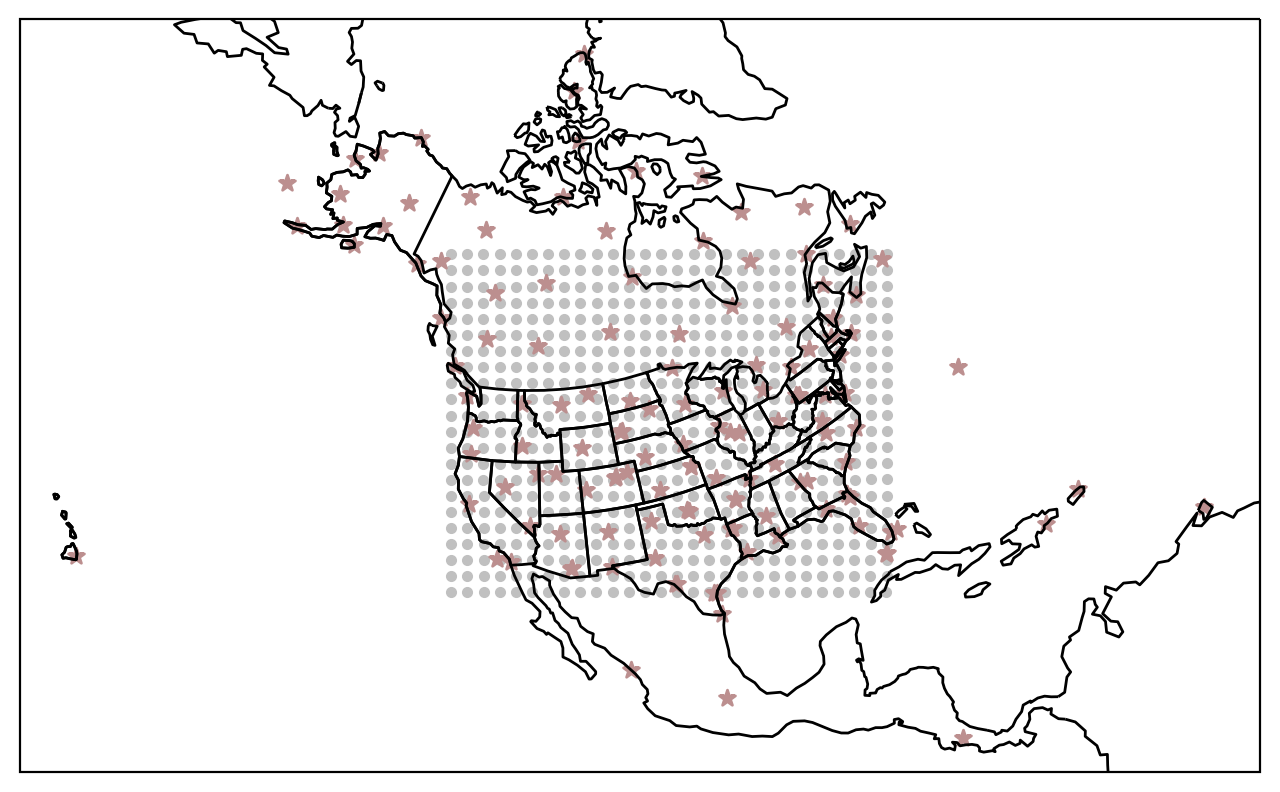

In [8]:
## Plot Obs and Grid Locations for Verification ##

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(grid_lon.ravel(), grid_lat.ravel(), c='silver', marker='.', transform = ccrs.PlateCarree())
ax1.scatter(data_lon, data_lat, c='rosybrown', marker='*', transform = ccrs.PlateCarree())

#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\Obs_and_Grid_Locations.png")

plt.show()

## __DO THE SOA ALGORITHM__
   $ f_A(r_i) = f_B(r_i) + sum(W * [f_o(r_k)-f_B(r_k)]) $
* so far only have observation values at obs locations: $ f_o(r_k) $
* will need to compute:
    1. $ f_B(r_i) $: background values at grid points 
    1. $ f_B(r_k) $: background values at observation stations 
    1. $ W $: the weights: *sum (W_ik • bec_kl) = bec_ik*
        - Compute the weights $ W $ using matrices:
            * *sum(W_ik • bec_kl) = bec_ik*   -->   *W_ik = bec_kl^(-1) • bec_ik*
                * *bec_kl* is the background error correlation between 2 obs locations
                * *bec_ik* is the background error correlation between an obs and grid location
        - Correlations are computed using: 
             * $ bec = 0.95 * exp(-1.24 * s²) $ 
                 * $ s $ is the distance on Earth in 1000s of km
###### *about here is where a mental breakdown occurs*
##### --> after that, the analysis values can be computed: $ f_A(r_i) $


#### 1. Get 'background values' at the grid points $ f_B(r_i) $

In [9]:
## empty matrix to be filled later with the background values
fbi = np.zeros((x_n, y_n)) ##for our f_B (r_i) values

###############################################################################################################

#fbi = sum(weights * fo) --> (f_B (r_i))
for m in range(len(x_grid)):
    for n in range(len(x_grid[0])):
        rel_x = x_grid[m,n] - x_ob ## subtract the obs from the grid points...
        rel_y = y_grid[m,n] - y_ob ## ...to get relative distance for the map
        radius = (rel_x**2 + rel_y**2)**(1/2) ## 'radius of influence' for ith analysis point
        index_re = np.where(radius <= re)[0] ## gives indices of obs within RoI
            
        #calculate weights for each observation point using Barnes weight function
        weights = np.zeros(len(x_ob)) ## create empty matrix for weights
        for ä in index_re:
            w = barnes(radius[ä]) #call the Barnes function created previously
            weights[ä] = w #store the a-priori values
        W = weights/np.nansum(weights) #calculate the a-posteriori weights
            
        #these are the background values at the grid points (f_B(r_i))
        fbi[m,n] = np.sum(W * fo)

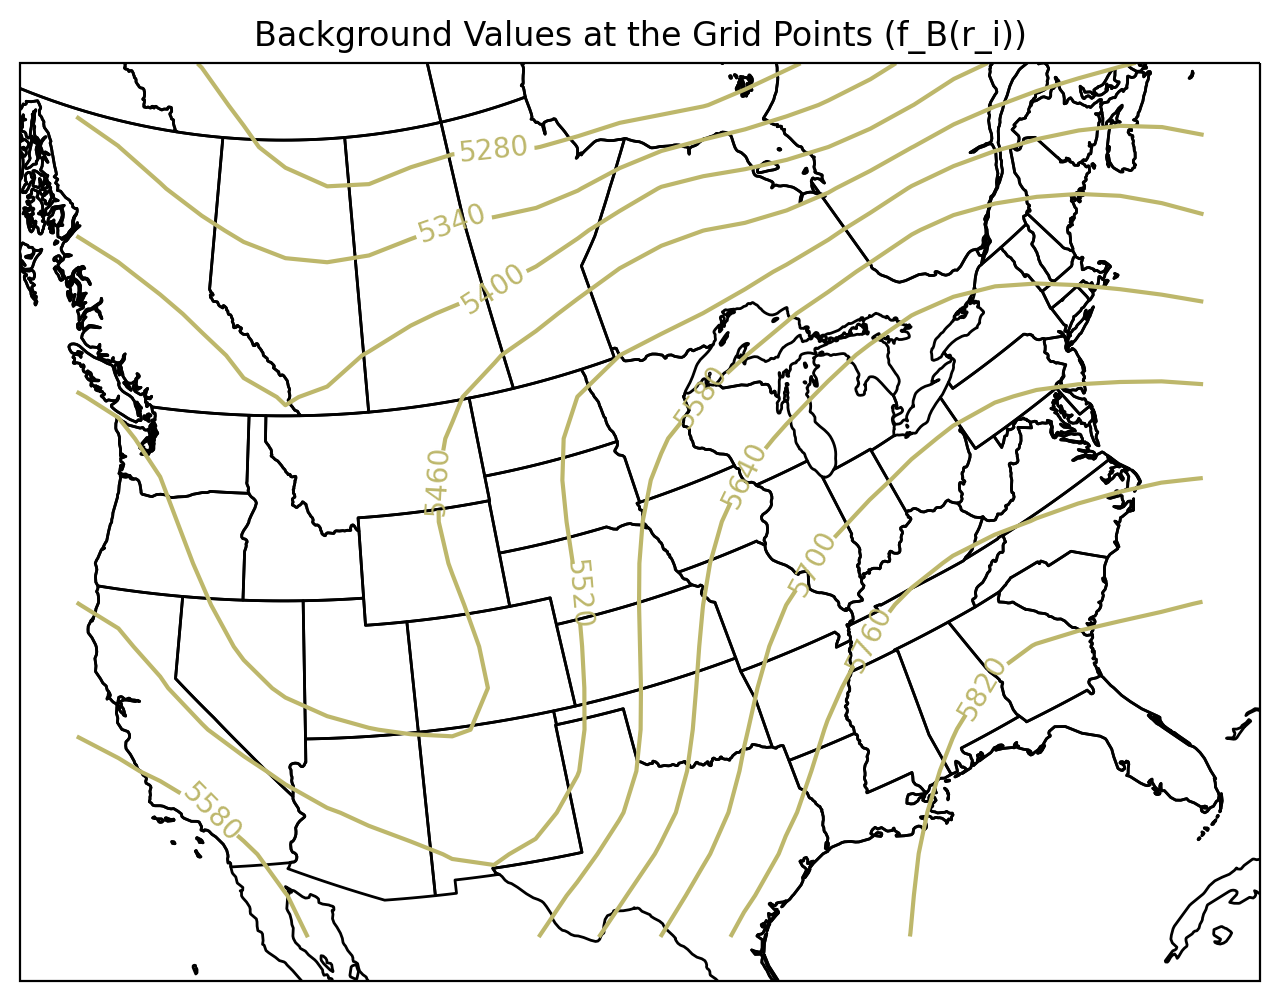

In [10]:
## Plot f_B(r_i) Values for Verification

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,fbi,colors='darkkhaki',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("Background Values at the Grid Points (f_B(r_i))")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\f_B(r_i).png")
plt.show()

#### 2. Get 'background values' at the observation stations $ f_B(r_k) $
* use 'background values' from previous run ($ f_B(r_i) $) in the bilinear interpolation formula

In [11]:
## empty matrix to be filled later with the background values
fbk = np.zeros((len(x_ob))) ##for our f_B (r_k) values

#redefine index values for our obs to our grid
ind_x = (x_ob - xo)/delta_x
ind_y = (y_ob - yo)/delta_y

###############################################################################################################

## get background values at obs locations --> (f_B (r_k))
for ß in range(len(ind_x)):
    # if the obs location is in our grid, do bilinear interpolation
    if (ind_x[ß] >= 0 and ind_x[ß] < 21) and (ind_y[ß] >= 0 and ind_y[ß] < 27):
        P = bilinearbgd(ind_x[ß], ind_y[ß])
            
    # if the obs location is outside of our grid, do a 'reverse Barnes'
    else:
        rel_xg = x_ob[ß] - x_grid #subtract the grid from the obs ...
        rel_yg = y_ob[ß] - y_grid #...to get relative distance for the map
        radius_g = (rel_xg**2 + rel_yg**2)**(1/2) #'radius of influence' for ith obs point
        index_re_g = np.where(radius_g <= re) #gives indices of obs within RoI
            
        ## do a weight function again, but now for giving weights to analyses to get that 'background value'
        weights_g = np.zeros(x_grid.shape)
        for µ in index_re_g[0]:
            for s in index_re_g[1]:
                w_g = barnes(radius_g[µ,s]) 
                weights_g[µ,s] = w_g #a-priori weights
        W_g = weights_g/np.nansum(weights_g) #a-posteriori weights
        P = np.sum(W_g * fbi)
        
    ## these are the background values at the obs locations (f_B (r_k))
    fbk[ß] = P

C:\Users\julia\AppData\Local\Temp\ipykernel_18952\3515484027.py:29: RuntimeWarning: invalid value encountered in divide
  W_g = weights_g/np.nansum(weights_g) #a-posteriori weights


#### 3. Compute the weights and the analysis values
1. Background Error Correlation between 2 obs locations: *bec_kl*
2. Background Error Correlation between an obs locations & a grid point: *bec_ik* 
* correlation given by: *bec = 0.95 • exp(-1.24 • s²)*
    * with $ s = 2 * rho * arcsin(sqrt[([sin([y_1-y_2]/2)]²)+(cos(y_2)*cos(y_1)*[(sin[(x_1-x_2)/2])²])]) $
3. Weights: *W = W_ik = bec_kl^(-1) • bec_ik*
4. Analysis Values: $ f_A(r_i) = f_B(r_i) + sum(W * [f_o(r_k)-f_B(r_k)]) $

In [12]:
fa = np.zeros((x_n, y_n, len(N_arr)))
for i in range(len(N_arr)):
    N = N_arr[i]
    for m in range(len(x_grid)):
        for n in range(len(x_grid[0])):
            rel_x = x_grid[m,n] - x_ob #subtract your obs from your analysis to get...
            rel_y = y_grid[m,n] - y_ob #...relative distance for our map
            radius = (rel_x**2 + rel_y**2)**(1/2) #'radius of influence' for ith analysis point
            index_re = np.argsort(radius) #gives indices of radius matrix from closest to furthest away
            indices = index_re[:N] #will use either the 2, 4, or 10 closest stations
            
            ## use only the data that's within N
            this_data_lat = data_lat[indices] * np.pi/180. #convert to radians
            this_data_lon = data_lon[indices] * np.pi/180. #convert to radians
            these_heights = fo[indices]
            these_bgd = fbk[indices]
            
            ###############################################################################################################

            ## calculate s (distance between obs points // obs point and grid point)
            dist_oo_km = np.zeros((len(indices),len(indices)))
            dist_og_km = np.zeros((len(indices)))
            for ü in range(len(this_data_lat)):
                #distance between two obs points
                d = 2 * earth * np.arcsin(np.sqrt(((np.sin((this_data_lat-this_data_lat[ü])/2))**2)+(np.cos(this_data_lat[ü])*np.cos(this_data_lat)*((np.sin((this_data_lon-this_data_lon[ü])/2))**2)))) #get the distance
                dist_oo_km[:,ü]=d
                
                # distance between obs point and grid point
                d = 2 * earth * np.arcsin(np.sqrt(((np.sin((this_data_lat[ü]-rad_grid_lat[m,n])/2))**2)+(np.cos(rad_grid_lat[m,n])*np.cos(this_data_lat[ü])*((np.sin((this_data_lon[ü]-rad_grid_lon[m,n])/2))**2)))) #get the distance
                dist_og_km[ü]=d
            
            # convert distances into 1000s of km   
            dist_oo = dist_oo_km / 1000
            dist_og = dist_og_km / 1000
            #make the really small numbers 0 because they are likely the diaginal values (the distance from an ob to itself)
            dist_oo[dist_oo <= 0.0000001] = 0
            
            ###############################################################################################################

            ## get correlations: bec = 0.95 * exp(-1.24 * s²)
            bec_kl = np.zeros((len(indices),len(indices)))
            bec_ik = np.zeros((len(indices)))
            
            #between obs points
            for ä in range(len(dist_oo[0])):
                for ö in range(len(dist_oo[1])):
                    #if s=0, then correlation is 1 because it's with itself
                    if dist_oo[ä,ö] == 0:
                        becoo = 1
                    else:
                        becoo = 0.95 * np.exp((-1.24) * (dist_oo[ä,ö]**2))
                    bec_kl[ä,ö] = becoo
            bec_kl = np.matrix(bec_kl)
            
            # between obs point & grid point
            for q in range(len(dist_og)):
                #if s=0, then correlation is 1 because it's with itself
                if dist_og[q] == 0:
                    becog = 1
                else:
                    becog = 0.95 * np.exp((-1.24) * (dist_og[q]**2))
                bec_ik[q] = becog
            bec_ik = np.matrix(bec_ik).T
            
            ###############################################################################################################

            # calculate the weights: W_ik = bec_kl^(-1) • bec_ik* 
            wik = np.linalg.inv(bec_kl) * bec_ik
            wik = np.array(wik).flatten()
            
            # calculate the analysis values at the grid points
            fa[m,n,i] = fbi[m,n] + np.sum((wik * (these_heights-these_bgd)))
            

## __CRYING IS OVER SO CAN ANALYZE THE FINDINGS__
1. Analysis Increment Fields: $ f_a(r_i)-f_b(r_i) $
1. Analysis Differences: $ f_a(r_k)-f_o(r_k) $
1. RMS Differences: $ sqrt(sum[f_o(r_k)-f_a(r_k)]²/K) $

In [13]:
### Analysis Increment Fields ###

ai = np.zeros((x_n, y_n, len(N_arr)))
# N=2
ai[:,:,0] = fa[:,:,0] - fbi[:,:]
# N=4
ai[:,:,1] = fa[:,:,1] - fbi[:,:]
# N=10
ai[:,:,2] = fa[:,:,2] - fbi[:,:]

In [14]:
### Get the analysis values at the observation stations ###

# empty matrix to be filled later with the analysis values at obs points
fak = np.zeros((len(x_ob), len(N_arr))) ##for our f_a (r_k) values

###############################################################################################################

## get analysis values at obs locations --> (f_a (r_k))
for i in range(len(N_arr)):
    N = N_arr[i]
    for ß in range(len(ind_x)):
        # if the obs location is in our grid, do bilinear interpolation
        if (ind_x[ß] >= 0 and ind_x[ß] < 21) and (ind_y[ß] >= 0 and ind_y[ß] < 27):
            P = bilinearanl(ind_x[ß], ind_y[ß], i)
            
        # if the obs location is outside of our grid, do a 'reverse Barnes'
        else:
            rel_xg = x_ob[ß] - x_grid ## subtract your grid from your obs to get...
            rel_yg = y_ob[ß] - y_grid ## ...relative distance for our map
            radius_g = (rel_xg**2 + rel_yg**2)**(1/2) ## 'radius of influence' for ith obs point
            index_re_g = np.where(radius_g <= re) ## gives indices of obs within RoI
            
            ## do a weight function again, but now for giving weights to analyses to get that 'background value'
            weights_g = np.zeros(x_grid.shape)
            for µ in index_re_g[0]:
                for s in index_re_g[1]:
                    w_g = barnes(radius_g[µ,s]) 
                    weights_g[µ,s] = w_g #a-priori
            W_g = weights_g/np.nansum(weights_g) #a-posteriori
            P = np.sum(W_g * fa[:,:,i])
        ## these are the analysis values at the obs locations (f_A (r_k))
        fak[ß,i] = P

C:\Users\julia\AppData\Local\Temp\ipykernel_18952\740403333.py:29: RuntimeWarning: invalid value encountered in divide
  W_g = weights_g/np.nansum(weights_g) #a-posteriori


In [15]:
### Analysis Difference Fields ###

ad = np.zeros((len(x_ob), len(N_arr)))
# N=2
ad[:,0] = fak[:,0] - fo
# N=4
ad[:,1] = fak[:,1] - fo
# N=10
ad[:,2] = fak[:,2] - fo

In [16]:
### Root Mean Square Differences ###

# calculate Root Mean Square Differences between analyses & obs at obs locations
# rms = sqrt (sum(fo-fak)²/K)
rms = np.zeros((len(N_arr)))

# N=2
dif_2 = (fo-fak[:,0])**2 #fak is our f_A (r_k) values
dif_2 = dif_2[~np.isnan(dif_2)] #delete the nan values
rms[0]=np.sqrt((np.sum(dif_2))/len(dif_2))

# N=4
dif_4 = (fo-fak[:,1])**2 #fak is our f_A (r_k) values
dif_4 = dif_4[~np.isnan(dif_4)] #delete the nan values
rms[1]=np.sqrt((np.sum(dif_4))/len(dif_4))

# N=10
dif_10 = (fo-fak[:,2])**2 #fak is our f_A (r_k) values
dif_10 = dif_10[~np.isnan(dif_10)] #delete the nan values
rms[2]=np.sqrt((np.sum(dif_10))/len(dif_10))

## __PLOTTING TIME__
1. Analyses (N=2, N=4, & N=10)
1. Analysis Increment Fields

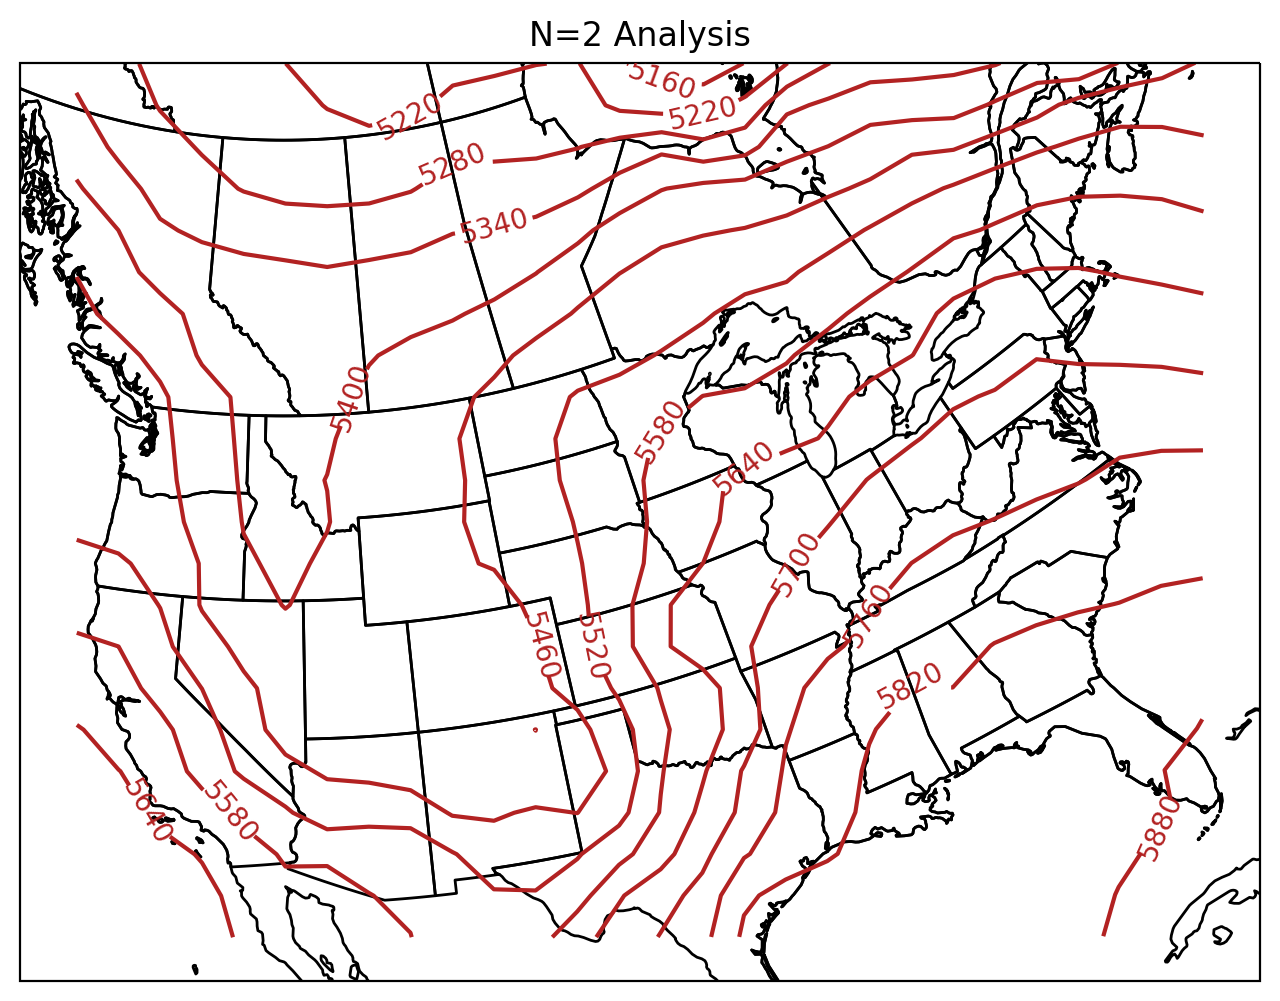

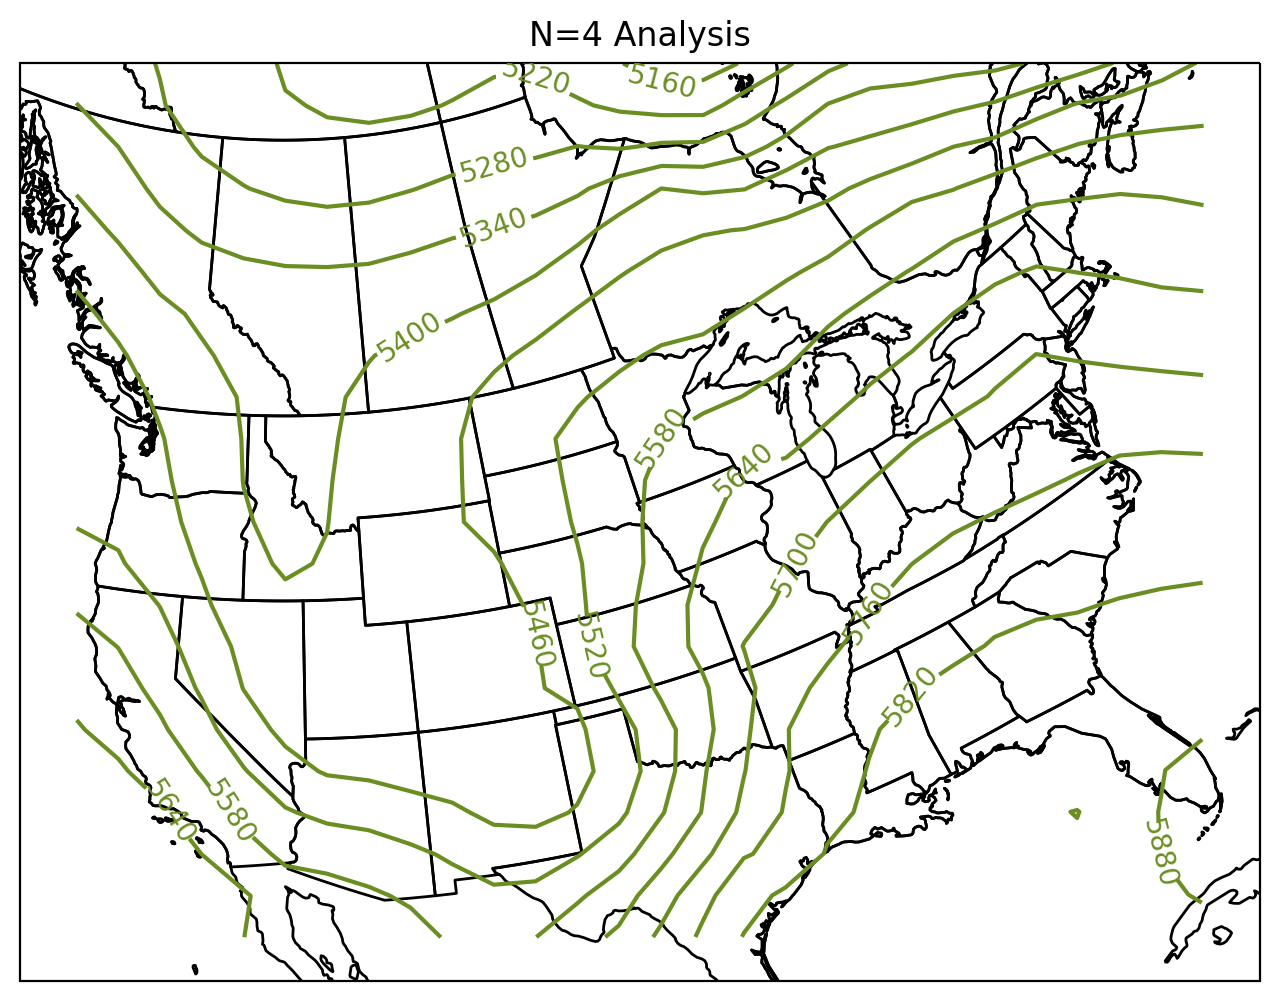

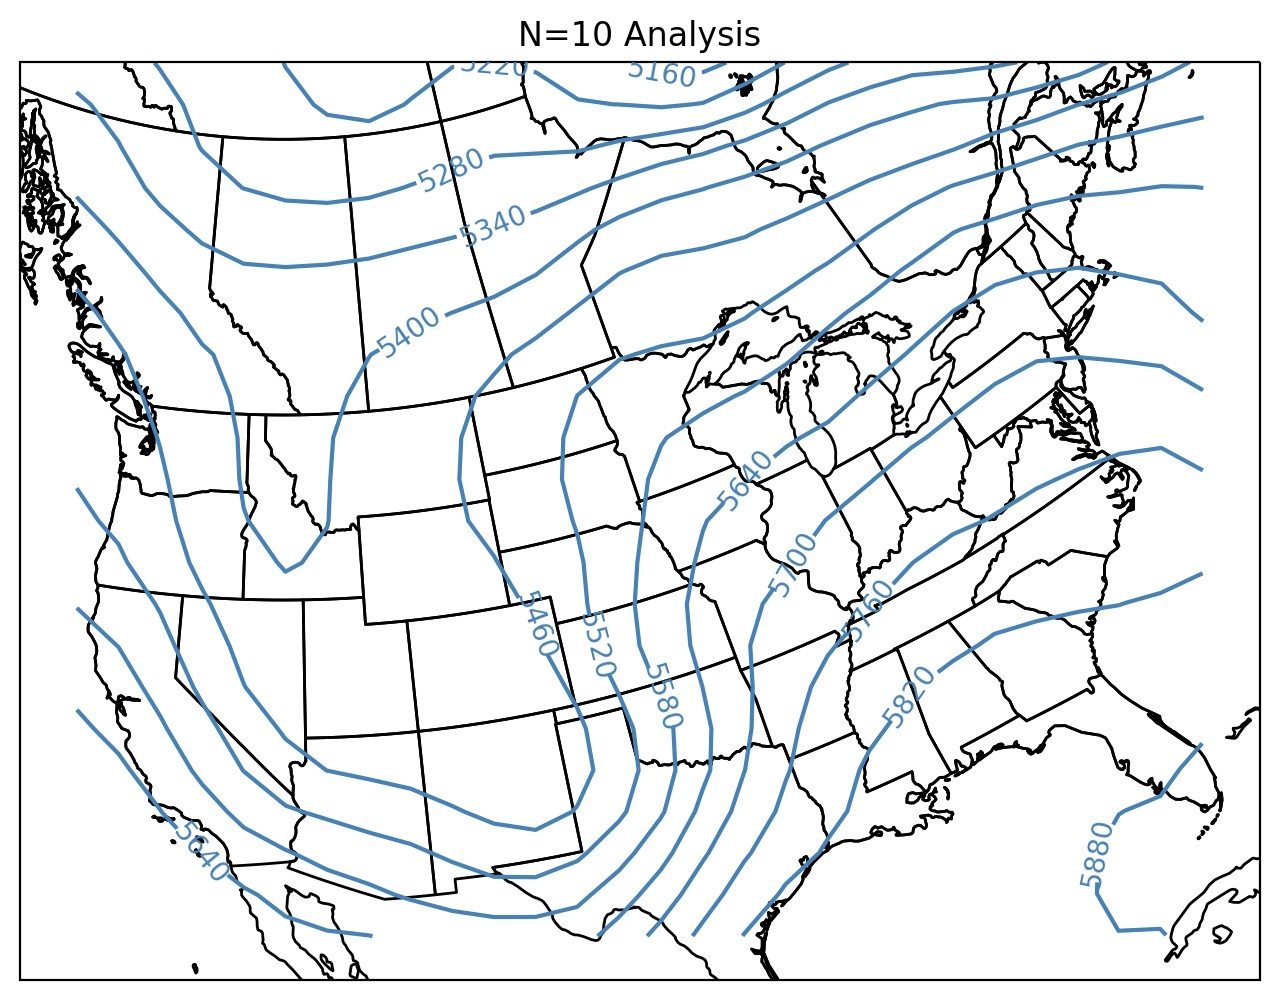

In [17]:
### Plot 500mb Analyses on a Map ###

## N = 2 (use the 2 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,fa[:,:,0],colors='firebrick',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=2 Analysis")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=2_Analysis.png")
plt.show()


## N = 4 (use the 4 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,fa[:,:,1],colors='olivedrab',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=4 Analysis")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=4_Analysis.png")
plt.show()


## N = 10 (use the 10 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,fa[:,:,2],colors='steelblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("N=10 Analysis")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=10_Analysis.png")
plt.show()

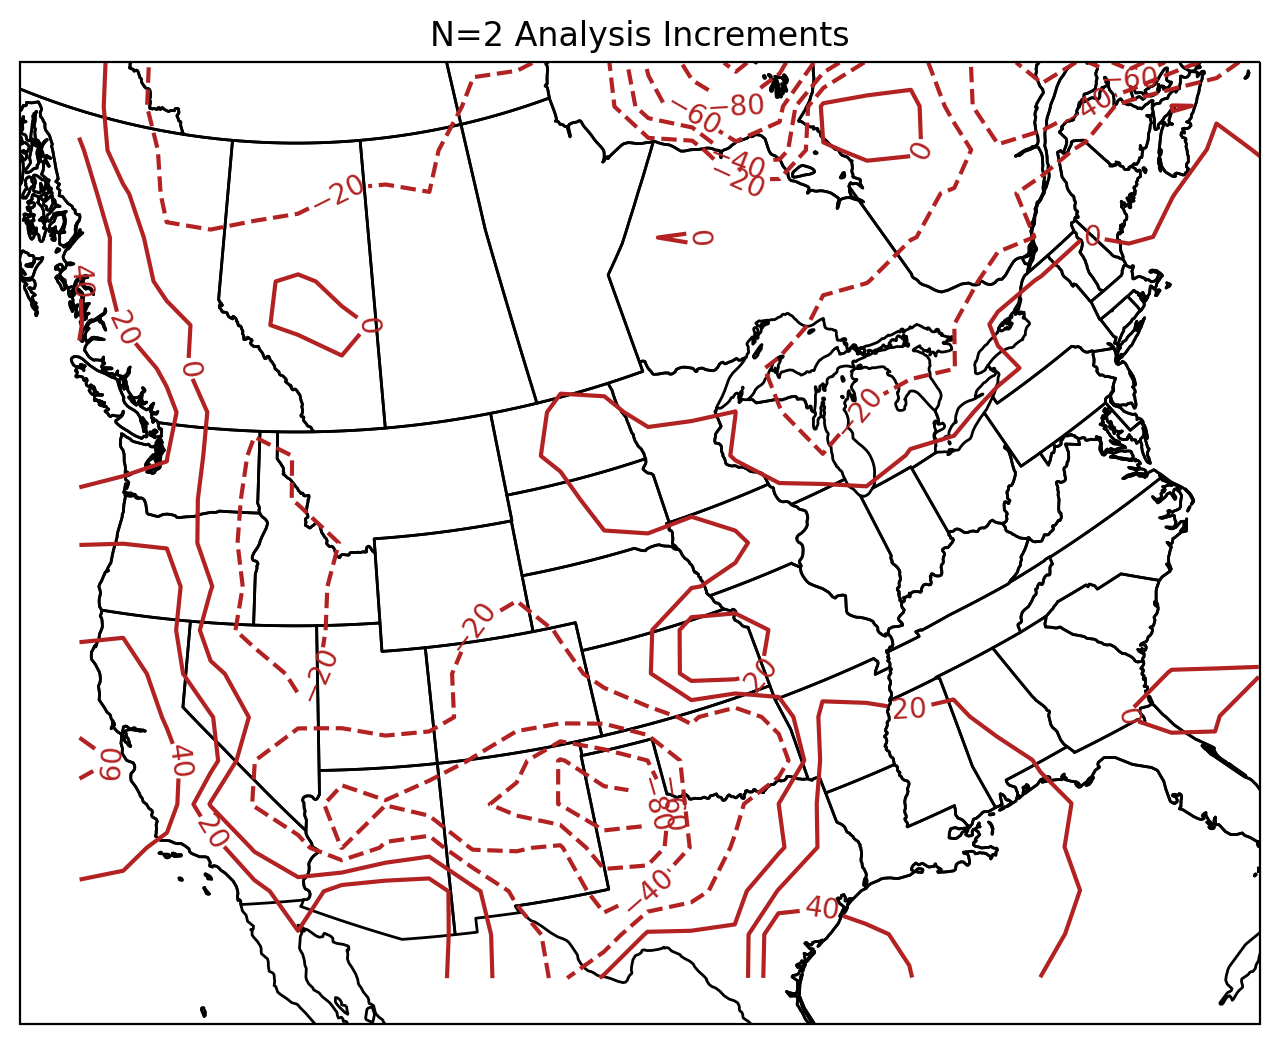

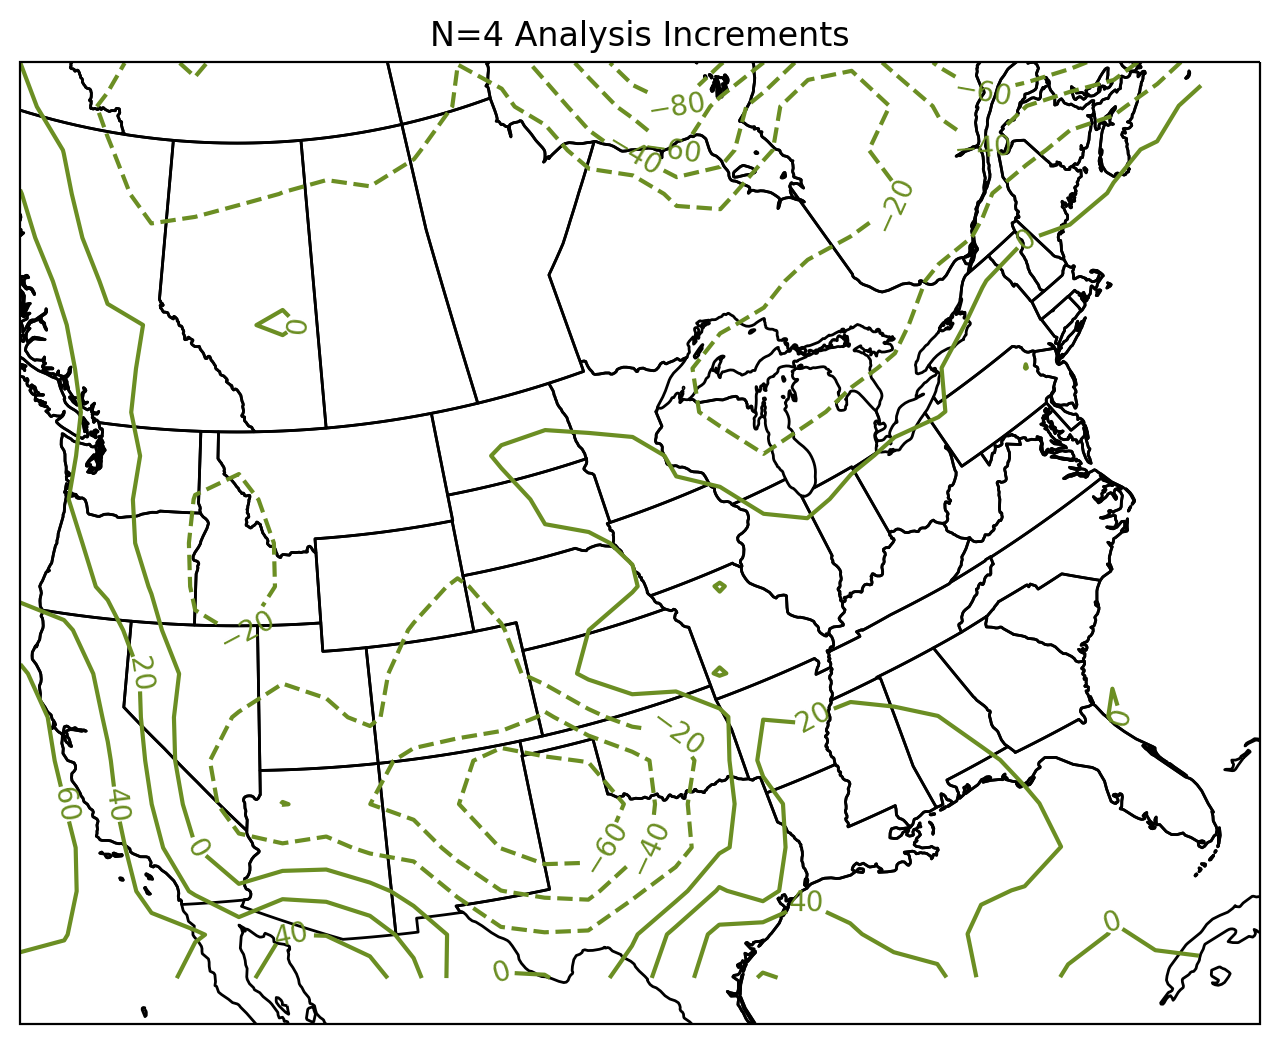

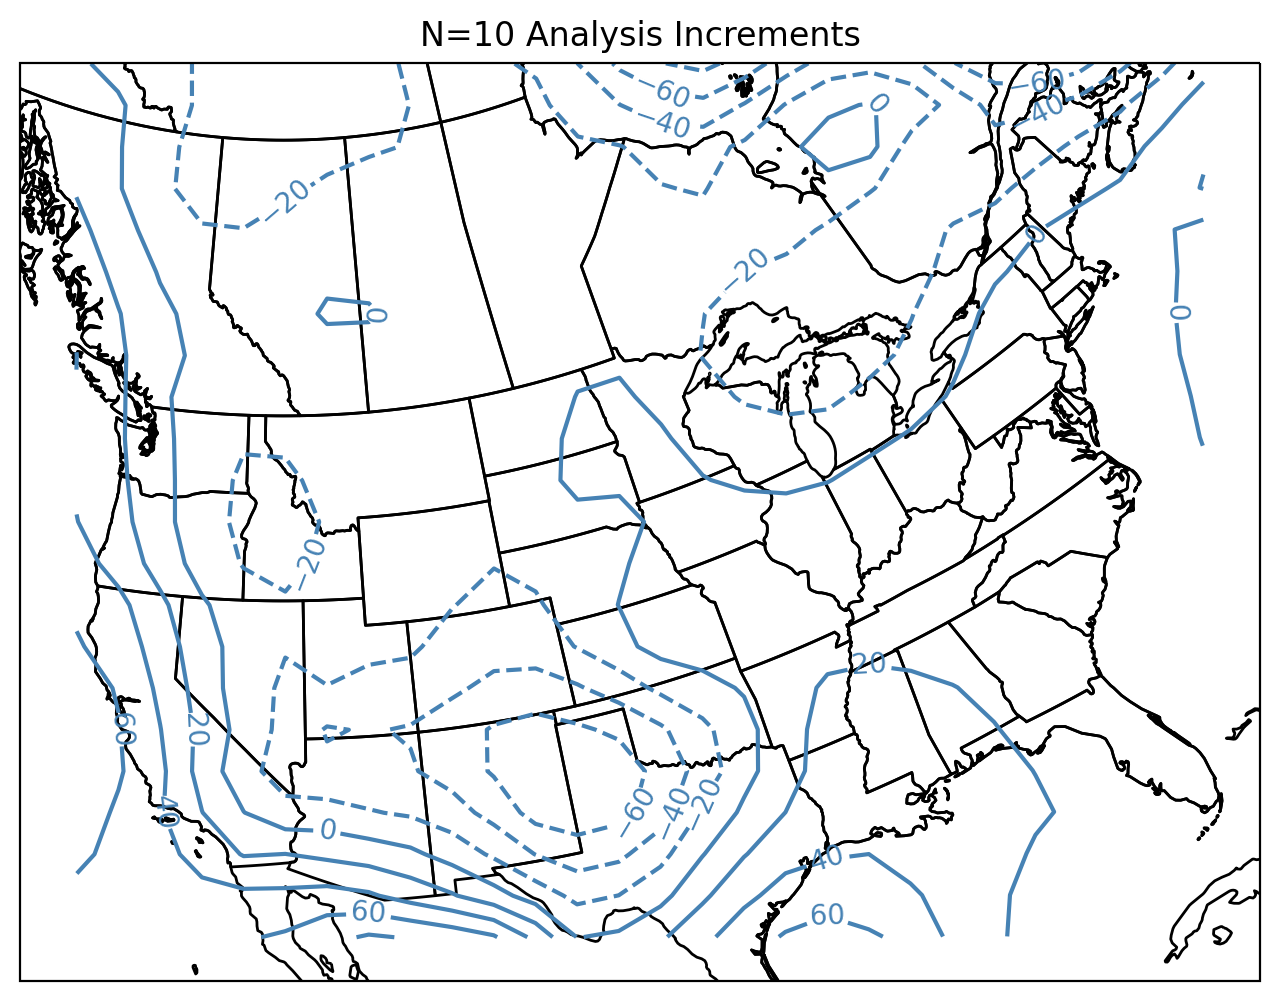

In [18]:
### Plot Analysis Increments on a Map ###

## N = 2 (use the 2 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ai[:,:,0],colors='firebrick',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title("N=2 Analysis Increments")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=2_Analysis_Increment.png")
plt.show()


## N = 4 (use the 4 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ai[:,:,1],colors='olivedrab',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title("N=4 Analysis Increments")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=4_Analysis_Increment.png")
plt.show()


## N = 10 (use the 10 closest stations)
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ai[:,:,2],colors='steelblue',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title("N=10 Analysis Increments")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=10_Analysis_Increment.png")
plt.show()

## __STORE IT ALL IN TEXT FILES__

In [19]:
### Store the analyses in text files ###
with open('analysis_values.txt', 'wb') as f:
    for line in fa:
        np.savetxt(f, line)


### Store the analysis increment fields in text files ###
with open('analysis_increments.txt', 'wb') as f:
    for line in ai:
        np.savetxt(f, line)
        
        
### Store the analysis difference fields in text files ###
with open('analysis_differences.txt', 'wb') as f:
    for line in ad:
        np.savetxt(f, line)
        
        
### Store RMS values in text file ###
rms_file = open('root_mean_square_differences.txt', 'w+')
rms_string = str(rms)
rms_file.write(rms_string)
rms_file.close()

## __~finis code__

### Answer the following questions:

1 - *Describe the general features that you see in your contoured analyses.*

    All three contour plots show a large-scale, negatively tilted trough over the Rockies. This trough stretches from Canada to Texas. For all, the 540 dam contour dips down into Idaho, but remains in Canada the rest of the way for all plots. This implies spring or fall. There is a weak ridge over the eastern US. Texas may be experiencing very strong winds at 500mb, as there is a strong 'height gradient' present. There is a large gap between the 540dam and the 546dam height contours. All three plots look very similar to one another. Additionally, the N = 10 analysis looks strikingly similar to the Third Pass from the Successive Corrections homework.
    
2 - *Describe the differences that you see in your contoured analyses. Does one analysis seem to be smoother than the other?  If so, what would cause this?*
    
    All three of our contour plots look very similar, with the only differences being very subtle. The only noticeable difference in the contours is the 540dam line. As more obs are included in the analysis, the 540dam line retreats northward slightly (N=2 it was south of the ID/NV border; N=10 approx. Ketchum,ID). 
    
    The biggest difference, however, is the smoothness- the more obs that are used in the analysis, the smoother. The N = 10 plot is the smoothest of the three, with the N = 2 being the most jagged. This is most likely due to representativeness error- the more obs that are included the more likely this error can be reduced. For example, if there is a thunderstorm in Grand Forks while your measurement was taking place, if you only use that one ob to find the current conditions in Hillsboro vs. using 10 obs, there would be a noticeable difference. In addition, when there are less input values, the contours have to 'work harder' to fit the irregular points, rather when there's more input and the transitions between data points is smoothed out. This reduces local features, and put more focus on large-scale features. Maps that fit all observations look terrible (but don't go too smooth.. that looks weird too).

3 - *What happens as you increase the number of points considered for the analysis?  Is this desirable?  Why or why not?*

    The more points that are used, the smoother the analysis gets. When there's less obs used, small-scale features come to light more than when more obs are used. More obs makes for more large-scale features being pronounced as the data gets more averaged out. However, in our maps, there is very little difference between them. Yes, the N=10 map is smoother, but they look quite similar on a whole. Kind of looks like the same map was drawn, but once you were iron deficient (N=2) and once your iron level was great (N=10). 
    
    This is desirable for 500mb/upper air analyses as no one should be looking at these maps for small scale features. When utilizing these maps, large-scale features are what you want to see, so smoothness is not an issue. In fact, smoothing makes it easier to pick out the large-scale features.
    

C:\Users\julia\anaconda3\envs\atsc528\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


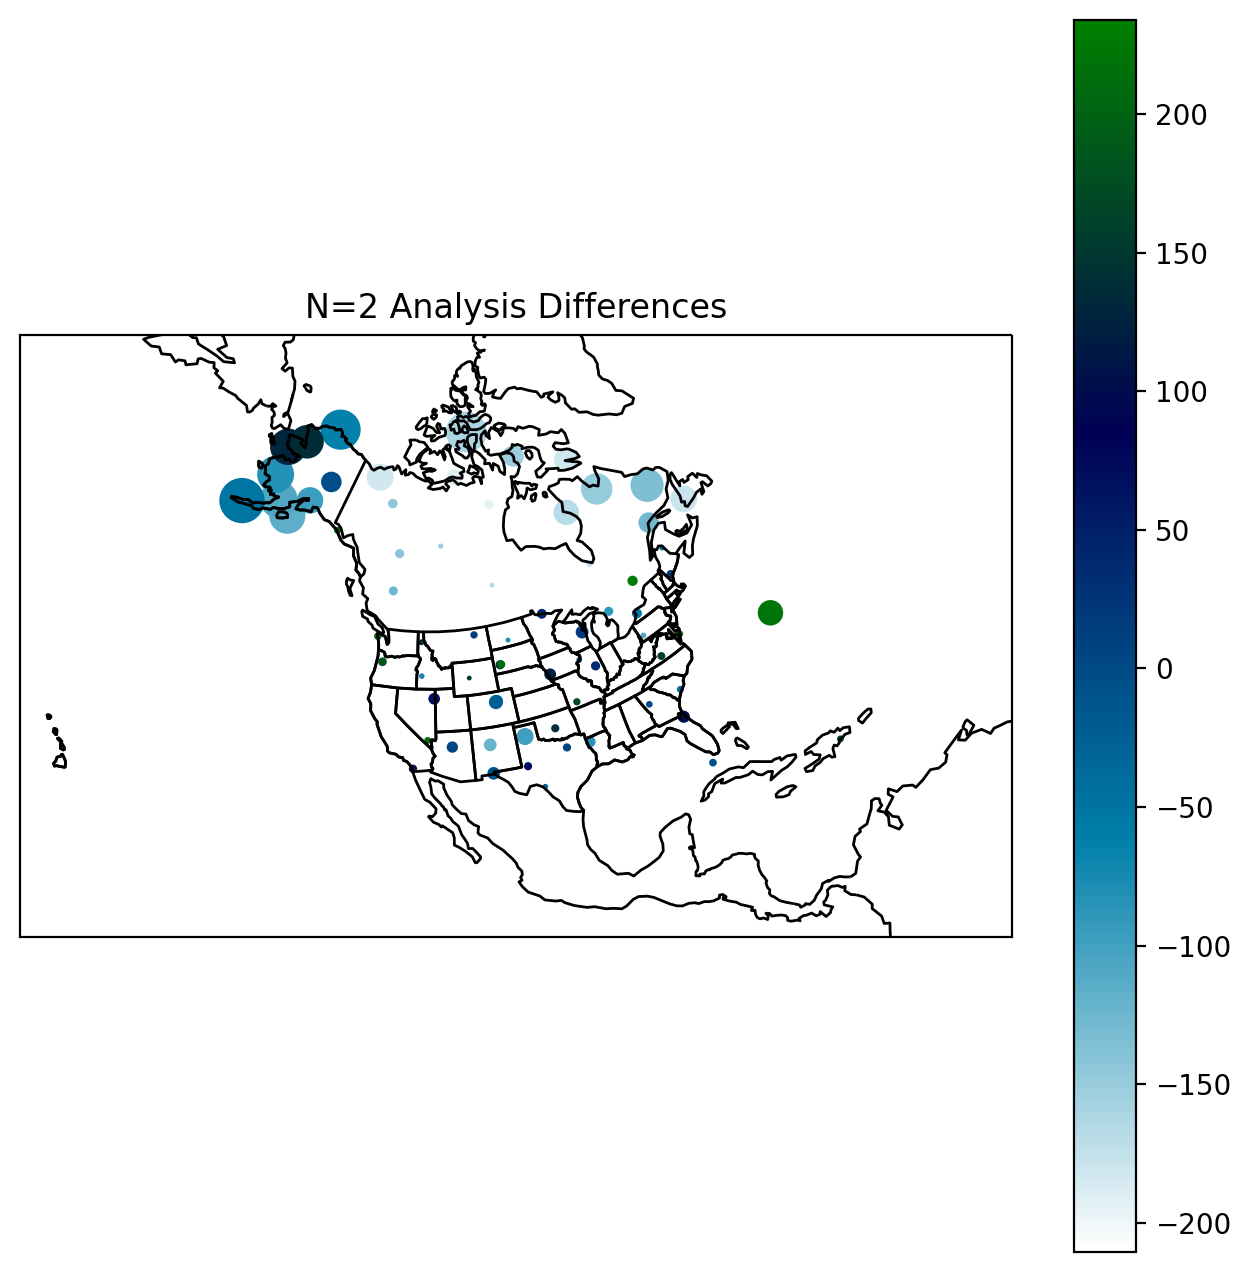

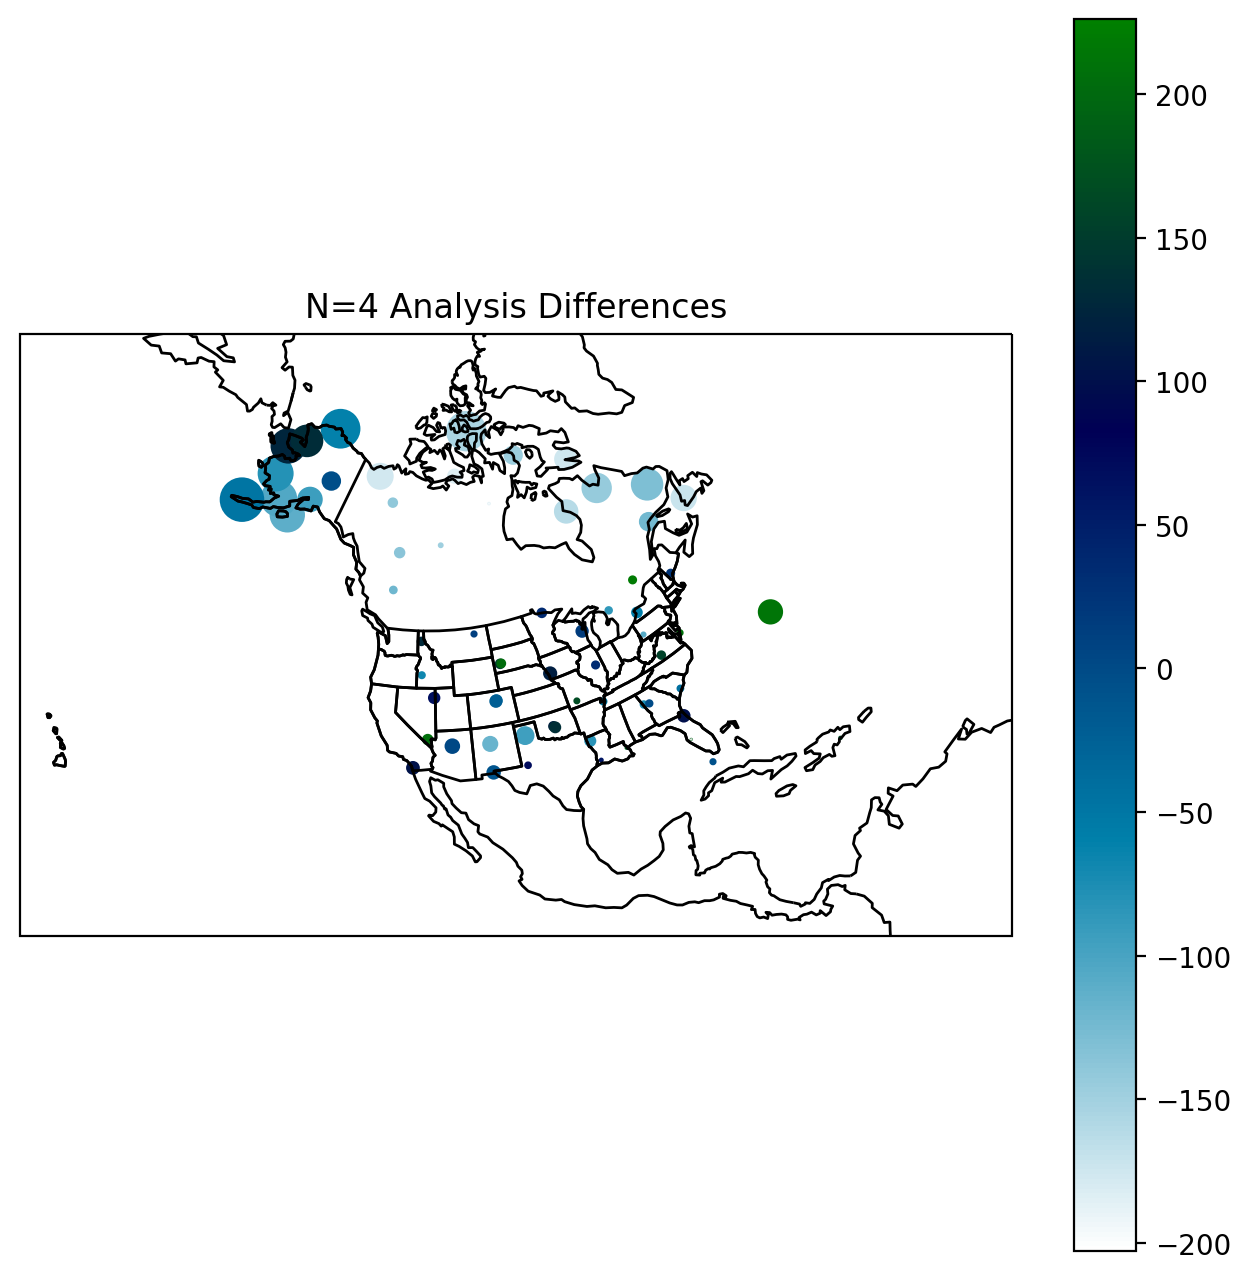

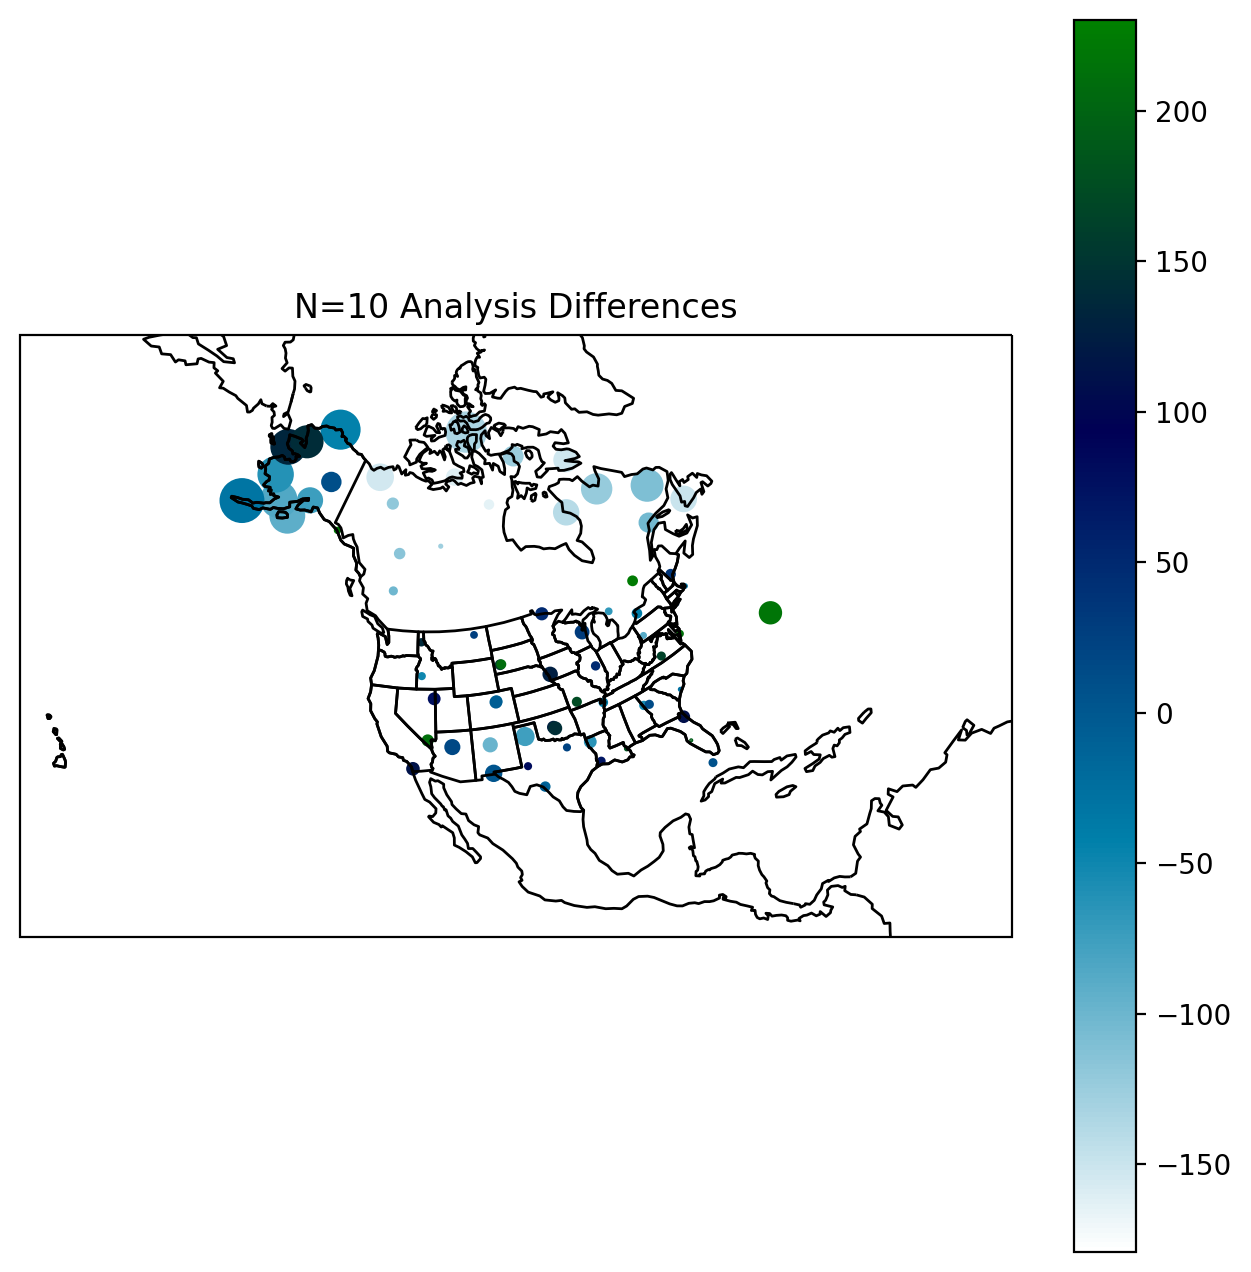

In [20]:
### Plot Analysis Differences on a Map ###
### THIS IS JUST FOR FUN!!! ###

palette = sns.color_palette("ocean_r",135)

## N = 2 (use the 2 closest stations)
nanad_2 = np.zeros(len(ad))
nanad_2 = ad[:,0][~np.isnan(ad[:,0])]
vmin2, vmax2 = np.min(nanad_2), np.max(nanad_2)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(data_lon, data_lat, ad[:,0], color=palette, transform = ccrs.PlateCarree())
plt.title("N=2 Analysis Differences")
sm = plt.cm.ScalarMappable(cmap='ocean_r', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
sm.set_array([])
fig.colorbar(sm)
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=2_Analysis_Difference.png")
plt.show()


## N = 4 (use the 4 closest stations)
nanad_4 = np.zeros(len(ad))
nanad_4 = ad[:,1][~np.isnan(ad[:,1])]
vmin4, vmax4 = np.min(nanad_4), np.max(nanad_4)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(data_lon, data_lat, ad[:,1], color=palette, transform = ccrs.PlateCarree())
plt.title("N=4 Analysis Differences")
sm = plt.cm.ScalarMappable(cmap='ocean_r', norm=plt.Normalize(vmin=vmin4, vmax=vmax4))
sm.set_array([])
fig.colorbar(sm)
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=4_Analysis_Difference.png")
plt.show()



## N = 10 (use the 10 closest stations)
nanad_10 = np.zeros(len(ad))
nanad_10 = ad[:,2][~np.isnan(ad[:,2])]
vmin10, vmax10 = np.min(nanad_10), np.max(nanad_10)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(data_lon, data_lat, ad[:,2], color=palette, transform = ccrs.PlateCarree())
plt.title("N=10 Analysis Differences")
sm = plt.cm.ScalarMappable(cmap='ocean_r', norm=plt.Normalize(vmin=vmin10, vmax=vmax10))
sm.set_array([])
fig.colorbar(sm)
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\03-Statistical_Objective_Analysis\\N=10_Analysis_Difference.png")
plt.show()